In [1]:
import pandas as pd

df = pd.read_csv("./veri776_metadata.csv") 
df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_val = df[df['split'] == 'validation'].reset_index(drop=True)
df_val

,label,cam_id,split,is_query,is_gallery,path
0,2,2,validation,True,True,veri776_ds\0002_c002_00030600_0.jpg
1,2,3,validation,True,True,veri776_ds\0002_c003_00084280_0.jpg
2,2,4,validation,True,True,veri776_ds\0002_c004_00084250_0.jpg
3,2,5,validation,True,True,veri776_ds\0002_c005_00084980_0.jpg
4,2,6,validation,True,True,veri776_ds\0002_c006_00083605_0.jpg
...,...,...,...,...,...,...
11574,776,7,validation,False,True,veri776_ds\0776_c007_00000595_0.jpg
11575,776,7,validation,False,True,veri776_ds\0776_c007_00000610_0.jpg
11576,776,7,validation,False,True,veri776_ds\0776_c007_00000620_0.jpg
11577,776,7,validation,False,True,veri776_ds\0776_c007_00000625_0.jpg


In [2]:
import argparse
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from metrics.eval_reid import *
from data.triplet_sampler import *
from typing import OrderedDict
from processor import get_model
import torch.multiprocessing
import os
import yaml
from utils import re_ranking

with open("./10/config.yaml", "r") as stream:
        data = yaml.safe_load(stream)


teste_transform = transforms.Compose([
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])                  

if data['half_precision']:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler=False


if data['dataset'] == 'Veri776':
    data_q = CustomDataSet4Veri776_withviewpont(data['query_list_file'], data['query_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_g = CustomDataSet4Veri776_withviewpont(data['gallery_list_file'], data['teste_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
    data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model = get_model(data, torch.device("cpu"))

# One of the saved weights last.pt best_CMC.pt best_mAP.pt
path_weights = './10/best_mAP.pt'

try:
    model.load_state_dict(torch.load(path_weights, map_location='cpu')) 
except RuntimeError:
    ### nn.Parallel adds "module." to the dict names. Although like said nn.Parallel can incur in weird results in some cases 
    tmp = torch.load(path_weights, map_location='cpu')
    tmp = OrderedDict((k.replace("module.", ""), v) for k, v in tmp.items())
    model.load_state_dict(tmp)


model = model.to(device)
model.eval()

mean = False
l2 = True

C:\Users\pnkdl\AppData\Local\Temp\ipykernel_816\1084257787.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Missed viewpoint for  0  images!
Missed viewpoint for  0  images!
Selected device: cuda


Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
C:\Users\pnkdl\AppData\Local\Temp\ipykernel_816\1084257787.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the lo

In [3]:
import torch.nn as nn


class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super(EmbeddingModel, self).__init__()
        self.original_model = original_model
    
    def forward(self, x):
        _, embs, _, _ = self.original_model(x, 0, 0)
        # Возвращаем объединенные эмбеддинги из всех ветвей
        return torch.cat(embs, dim=1)
    

embedding_model = EmbeddingModel(model)


In [4]:
teste_transform = transforms.Compose([
    transforms.ToTensor(),
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])  

In [5]:

from oml import datasets as d
from oml.inference import inference
from oml.metrics import calc_retrieval_metrics_rr
from oml.models import ViTExtractor
from oml.registry import get_transforms_for_pretrained
from oml.retrieval import RetrievalResults



first_step = d.ImageLabeledDataset(df_train, transform=teste_transform)
accumulation_steps = d.ImageQueryGalleryLabeledDataset(df_val, transform=teste_transform)



c:\Programming\veri_metric\unicom\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Programming\veri_metric\unicom\venv\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
embeddings_first = inference(embedding_model, first_step, batch_size=192, num_workers=0)

In [7]:
embeddings_accum = inference(embedding_model, accumulation_steps, batch_size=192, num_workers=0)

In [8]:
rr = RetrievalResults.from_embeddings(embeddings_accum, accumulation_steps, n_items=5)
print(1)
# rr = AdaptiveThresholding(n_std=2).process(rr)
# print(1)
print(calc_retrieval_metrics_rr(rr, map_top_k=(10000,), cmc_top_k=(1,)))

1


MAP@10000: 100%|██████████| 1678/1678 [00:00<00:00, 14319.22it/s]


{'cmc': {1: tensor(0.9952)}, 'precision': {5: tensor(0.9844)}, 'map': {10000: tensor(0.9956)}}


In [9]:
labels_first = [x['labels'] for x in first_step]
labels_first = np.array(labels_first)

In [10]:
labels_accum = [x['labels'] for x in accumulation_steps]
labels_accum = np.array(labels_accum)

In [11]:
import numpy as np

def split_dataset_by_classes(embeddings, labels, n_splits=5):
    # 1. Получаем уникальные классы
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)

    if n_classes < n_splits:
        raise ValueError(f"Недостаточно классов: {n_classes}, требуется минимум {n_splits}")

    # 2. Перемешиваем классы
    np.random.shuffle(unique_classes)

    # 3. Делим классы на n_splits групп
    class_groups = np.array_split(unique_classes, n_splits)

    # 4. Создаем список для хранения подчастей
    splits = []

    for group in class_groups:
        mask = np.isin(labels, group)
        splits.append((embeddings[mask], labels[mask]))

    return splits

In [12]:
splitted_steps = split_dataset_by_classes(embeddings_accum, labels_accum)

In [13]:
for i, (X_part, y_part) in enumerate(splitted_steps):
    print(f"Часть {i+1}: {len(X_part)} примеров, уникальные классы: {np.unique(y_part)}")

Часть 1: 2574 примеров, уникальные классы: [  6  35  90 113 135 143 179 188 241 247 273 281 294 296 300 318 365 368
 371 373 385 404 450 456 545 554 570 576 590 593 597 610 623 624 630 657
 662 677 727 771]
Часть 2: 2233 примеров, уникальные классы: [  2  27  30  38  74  89 110 142 145 162 166 182 183 192 205 207 262 327
 344 388 398 402 405 446 467 482 515 598 612 615 625 634 653 668 685 712
 742 761 772 775]
Часть 3: 2241 примеров, уникальные классы: [ 14  66  86 102 106 132 150 151 172 180 196 216 249 299 306 326 357 361
 369 417 420 473 476 510 518 522 546 569 582 586 609 622 654 660 672 698
 720 729 770 774]
Часть 4: 1979 примеров, уникальные классы: [ 42  61  96 101 105 108 118 122 129 130 144 154 231 237 240 295 298 310
 319 322 337 392 418 421 427 477 480 486 507 543 566 602 606 614 652 659
 676 699 773 776]
Часть 5: 2552 примеров, уникальные классы: [  5   9  63  65 104 117 126 134 173 174 177 197 218 219 288 315 332 380
 391 416 461 485 489 494 541 581 584 585 588 631 642 646

In [27]:
parts = []
parts = [{"embeddings": embeddings_first, "labels": labels_first}]
for i, (X_part, y_part) in enumerate(splitted_steps):
    parts.append({"embeddings": X_part, "labels": y_part})

In [28]:
from sklearn.model_selection import train_test_split
import numpy as np

# parts = [part1, part2, ..., part6]
# part = {"embeddings": embeddings_part, "labels": labels_part}

# Разделим каждую часть на train и val
train_val_parts = []

for part in parts:
    X_train, X_val, y_train, y_val = train_test_split(
        part["embeddings"], 
        part["labels"], 
        test_size=0.9,
        stratify=part["labels"],
        random_state=42
    )
    train_val_parts.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    })

In [51]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Сохраняем валидационные данные первой части
first_val_data = {
    "X": train_val_parts[1]["X_val"].numpy() if isinstance(train_val_parts[1]["X_val"], torch.Tensor) else train_val_parts[1]["X_val"],
    "y": train_val_parts[1]["y_val"].tolist() if isinstance(train_val_parts[1]["y_val"], torch.Tensor) else train_val_parts[1]["y_val"]
}

replay_buffer = {
    "X_train": [],
    "y_train": []
}

# Хранилище метрик
metrics_history = []

# Глобальный маппинг классов -> индекс
class_to_idx = {}
known_classes = set()

for i, part in enumerate(train_val_parts):
    print(f"\nЭтап {i+1}")
    
    # Получаем уникальные классы текущей части
    current_classes = np.unique(part["y_train"])
    
    # Обновляем маппинг классов
    for cls in current_classes:
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    
    # Формируем объединенные данные для KNN
    if i == 0:
        # Только текущие данные для первого этапа
        X_combined = part["X_train"].numpy() if isinstance(part["X_train"], torch.Tensor) else part["X_train"]
        y_combined = [class_to_idx[cls] for cls in part["y_train"]]
    else:
        # Преобразуем данные из реплей-буфера
        replay_X = [x.numpy() if isinstance(x, torch.Tensor) else x for x in replay_buffer["X_train"]]
        replay_y = []
        for batch in replay_buffer["y_train"]:
            batch_list = batch.tolist() if isinstance(batch, torch.Tensor) else batch
            for cls in batch_list:
                replay_y.append(class_to_idx[cls])
        
        # Добавляем текущие данные
        current_X = part["X_train"].numpy() if isinstance(part["X_train"], torch.Tensor) else part["X_train"]
        current_y = [class_to_idx[cls] for cls in part["y_train"]]
        
        # Объединяем
        X_combined = np.vstack([current_X] + replay_X)
        y_combined = current_y + replay_y
    
    # Обучение KNN
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_combined, y_combined)
    
    # Оценка на новых данных
    current_val_X = part["X_val"].numpy() if isinstance(part["X_val"], torch.Tensor) else part["X_val"]
    current_val_y = [class_to_idx[cls] for cls in part["y_val"]]
    new_preds = knn.predict(current_val_X)
    new_acc = accuracy_score(current_val_y, new_preds)
    
    old_acc = None
    if i >= 1:
        # Оценка на старых данных (первый этап)
        old_val_X = first_val_data["X"]
        old_val_y = [class_to_idx[cls] for cls in first_val_data["y"]]
        old_preds = knn.predict(old_val_X)
        old_acc = accuracy_score(old_val_y, old_preds)
    
         # --- Измерение времени инференса на одном элементе ---
    inference_time = 0.0
    if True:
        # Выбираем случайный элемент
        idx = np.random.randint(0, len(current_val_X))
        single_sample = current_val_X[idx:idx+1]

        # Замеряем время
        start_time = time.perf_counter()
        for _ in range(100):
                _pr = knn.predict(single_sample)
        end_time = time.perf_counter()

        # Среднее время на один элемент
        avg_inference_time = (end_time - start_time) / 100

        inference_time = avg_inference_time

    # --- Конец измерения времени ---

    # Сохраняем метрики
    metrics_history.append({
        "new": new_acc,
        "old": old_acc,
        "inference_time": inference_time  # в секундах
    })

    print(f"Accuracy на новых классах: {new_acc}")
    print(f"Accuracy на старых классах (первый этап): {old_acc}")
    print(f"Среднее время инференса на 1 элемент: {inference_time} сек")
    
    # Добавляем текущие данные в реплей-буфер
    X_current = part["X_train"].numpy() if isinstance(part["X_train"], torch.Tensor) else part["X_train"]
    y_current = part["y_train"].numpy() if isinstance(part["y_train"], torch.Tensor) else part["y_train"]
    replay_buffer["X_train"].append(X_current.copy())
    replay_buffer["y_train"].append(y_current.copy())


Этап 1
Accuracy на новых классах: 0.9916473044910444
Accuracy на старых классах (первый этап): None
Среднее время инференса на 1 элемент: 0.09390289600007236 сек

Этап 2
Accuracy на новых классах: 0.9283556322831247
Accuracy на старых классах (первый этап): 0.9283556322831247
Среднее время инференса на 1 элемент: 0.08240397299989127 сек

Этап 3
Accuracy на новых классах: 0.8970149253731343
Accuracy на старых классах (первый этап): 0.9236081139404402
Среднее время инференса на 1 элемент: 0.08138363899895922 сек

Этап 4
Accuracy на новых классах: 0.9444719881011403
Accuracy на старых классах (первый этап): 0.9192921881743634
Среднее время инференса на 1 элемент: 0.08305493199964985 сек

Этап 5
Accuracy на новых классах: 0.9382716049382716
Accuracy на старых классах (первый этап): 0.9063444108761329
Среднее время инференса на 1 элемент: 0.08347285700030625 сек

Этап 6
Accuracy на новых классах: 0.9299085764040053
Accuracy на старых классах (первый этап): 0.9033232628398792
Среднее время 

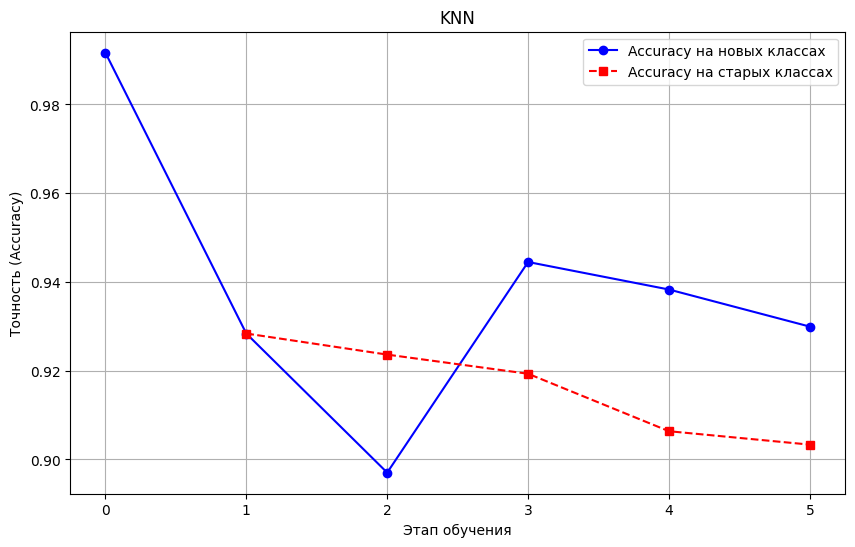

In [52]:
import matplotlib.pyplot as plt

# Список этапов
epochs = range(0, len(metrics_history))

# Списки точности для новых и старых классов
accuracy_new = [data['new'] for data in metrics_history]
accuracy_old = [data['old'] for data in metrics_history]

plt.figure(figsize=(10, 6))

# Построение графика точности для новых классов
plt.plot(epochs, accuracy_new, label='Accuracy на новых классах', marker='o', linestyle='-', color='blue')

# Построение графика точности для старых классов
plt.plot(epochs, accuracy_old, label='Accuracy на старых классах', marker='s', linestyle='--', color='red')

# Настройка осей и заголовка
plt.title('KNN')
plt.xlabel('Этап обучения')
plt.ylabel('Точность (Accuracy)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [49]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import faiss

# Гиперпараметры
pca_dim = 512  # Снижение размерности до 512
n_neighbors = 1  # Число соседей для KNN
use_pca = False  # Включить PCA

# Сохраняем валидационные данные первой части
# Сохраняем валидационные данные первой части
first_val_data = {
    "X": train_val_parts[1]["X_val"].numpy() if isinstance(train_val_parts[1]["X_val"], torch.Tensor) else train_val_parts[1]["X_val"],
    "y": train_val_parts[1]["y_val"].tolist() if isinstance(train_val_parts[1]["y_val"], torch.Tensor) else train_val_parts[1]["y_val"]
}

# Хранилище метрик
metrics_history = []

# Глобальный маппинг классов -> индекс
class_to_idx = {}
known_classes = set()

# Хранилище эмбеддингов и меток для FAISS
all_embeddings = []
all_labels = []

# PCA для снижения размерности
pca = PCA(n_components=pca_dim) if use_pca else None

# FAISS индекс
dimension = pca_dim if use_pca else 4096  # Размерность после PCA
index = faiss.IndexFlatL2(dimension)  # Используем L2 (евклидово расстояние)

# Поэтапная обработка
for i, part in enumerate(train_val_parts):
    print(f"\nЭтап {i+1}")
    
    # Получаем уникальные классы текущей части
    current_classes = np.unique(part["y_train"])
    
    # Обновляем маппинг классов
    for cls in current_classes:
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    
    # Преобразуем данные в numpy
    X_train = part["X_train"].numpy() if isinstance(part["X_train"], torch.Tensor) else part["X_train"]
    y_train = part["y_train"].tolist() if isinstance(part["y_train"], torch.Tensor) else part["y_train"]
    
    # Обучаем PCA на первом этапе
    if i == 0 and use_pca:
        print("Обучение PCA...")
        pca.fit(X_train)
    
    # Применяем PCA и нормализацию
    def process_embeddings(X):
        X = normalize(X)
        if use_pca:
            X = pca.transform(X)
        return X.astype(np.float32)

    X_train_processed = process_embeddings(X_train)

    # Добавляем в FAISS
    index.add(X_train_processed)

    # Сохраняем метки
    all_labels.extend([class_to_idx[cls] for cls in y_train])

    # Формируем валидационные данные
    X_val_new = part["X_val"].numpy() if isinstance(part["X_val"], torch.Tensor) else part["X_val"]
    X_val_new_processed = process_embeddings(X_val_new)
    y_val_new = [class_to_idx[cls] for cls in part["y_val"]]

    # Валидация на новых данных
    D, I = index.search(X_val_new_processed, n_neighbors)
    preds_new = [max(set([all_labels[i] for i in idxs]), key=([all_labels[i] for i in idxs]).count) for idxs in I]
    acc_new = accuracy_score(y_val_new, preds_new)


    acc_old = None
    if i >= 1:
        # Валидация на старых данных (первый этап)
        X_val_old_processed = process_embeddings(first_val_data["X"])
        D, I = index.search(X_val_old_processed, n_neighbors)
        preds_old = [max(set([all_labels[i] for i in idxs]), key=([all_labels[i] for i in idxs]).count) for idxs in I]
        acc_old = accuracy_score([class_to_idx[cls] for cls in first_val_data["y"]], preds_old)

     # --- Измерение времени инференса на одном элементе ---
    inference_time = 0.0
    if True:
        # Выбираем случайный элемент
        idx = np.random.randint(0, len(X_val_new_processed))
        single_sample = X_val_new_processed[idx:idx+1]

        # Замеряем время
        start_time = time.perf_counter()
        for _ in range(100):
            D, I = index.search(single_sample, n_neighbors)
        end_time = time.perf_counter()

        # Среднее время на один элемент
        avg_inference_time = (end_time - start_time) / 100

        inference_time = avg_inference_time

    # --- Конец измерения времени ---

    # Сохраняем метрики
    metrics_history.append({
        "new": acc_new,
        "old": acc_old,
        "inference_time": inference_time  # в секундах
    })

    print(f"Accuracy на новых классах: {acc_new}")
    print(f"Accuracy на старых классах (первый этап): {acc_old}")
    print(f"Среднее время инференса на 1 элемент: {inference_time} сек")


Этап 1
Accuracy на новых классах: 0.9913531954942502
Accuracy на старых классах (первый этап): None
Среднее время инференса на 1 элемент: 0.0023888800002168863 сек

Этап 2
Accuracy на новых классах: 0.9287872248597324
Accuracy на старых классах (первый этап): 0.9287872248597324
Среднее время инференса на 1 элемент: 0.002680991999804974 сек

Этап 3
Accuracy на новых классах: 0.8955223880597015
Accuracy на старых классах (первый этап): 0.9236081139404402
Среднее время инференса на 1 элемент: 0.0027786339994054286 сек

Этап 4
Accuracy на новых классах: 0.9444719881011403
Accuracy на старых классах (первый этап): 0.9188605955977557
Среднее время инференса на 1 элемент: 0.002854771000565961 сек

Этап 5
Accuracy на новых классах: 0.9382716049382716
Accuracy на старых классах (первый этап): 0.9067760034527406
Среднее время инференса на 1 элемент: 0.002971669000107795 сек

Этап 6
Accuracy на новых классах: 0.9277318241184154
Accuracy на старых классах (первый этап): 0.9033232628398792
Среднее

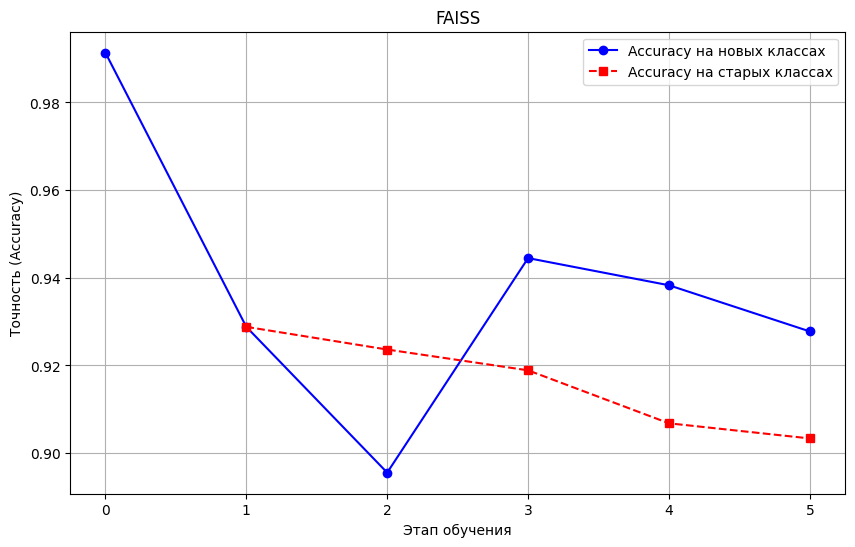

In [47]:
import matplotlib.pyplot as plt

# Список этапов
epochs = range(0, len(metrics_history))

# Списки точности для новых и старых классов
accuracy_new = [data['new'] for data in metrics_history]
accuracy_old = [data['old'] for data in metrics_history]

plt.figure(figsize=(10, 6))

# Построение графика точности для новых классов
plt.plot(epochs, accuracy_new, label='Accuracy на новых классах', marker='o', linestyle='-', color='blue')

# Построение графика точности для старых классов
plt.plot(epochs, accuracy_old, label='Accuracy на старых классах', marker='s', linestyle='--', color='red')

# Настройка осей и заголовка
plt.title('FAISS')
plt.xlabel('Этап обучения')
plt.ylabel('Точность (Accuracy)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()